In [317]:
import numpy as np
import librosa
from scipy.io import wavfile
from glob import glob
import re
import warnings
from numpy.random import random, uniform, randint, choice

In [393]:
class DataGenerator(object):
    def __init__(self, input_dir):

        self._input_files = None

        self.input_dir = input_dir
        self.sample_rate = 16000
        self.duration = 1.  # sec
        self.n_fft = 512
        self.n_mels = 64
        self.msg_w = 256

        # valid labels
        self.valid_labels = set([
            'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop',
            'go', 'unknown', 'silence'
        ])

        self.silence_files = glob(self.input_dir + '/_background_noise_/*.wav')

        # random mixing settings

        self.mix_with = {}

        self.mix_with[self.input_dir +
                      '/_background_noise_/doing_the_dishes.wav'] = {
                          'volume': [0.25, 0.75],
                          'probability': 0.2
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/exercise_bike.wav'] = {
                          'volume': [0.25, 0.75],
                          'probability': 0.2
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/white_noise.wav'] = {
                          'volume': [0.05, 0.5],
                          'probability': 0.2
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/dude_miaowing.wav'] = {
                          'volume': [0.25, 0.75],
                          'probability': 0.2
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/pink_noise.wav'] = {
                          'volume': [0.05, 0.5],
                          'probability': 0.2
                      }

        self.mix_with[self.input_dir +
                      '/_background_noise_/running_tap.wav'] = {
                          'volume': [0.25, 0.75],
                          'probability': 0.2
                      }

        # random transforms

        self.transforms = {
            'pitch': {
                'probability': 0.33,
                'range': [-10., 10.]
            },
            'speed': {
                'probability': 0.2,
                'range': [0.5, 2.]
            },
            'volume': {
                'probability': 0.2,
                'range': [0.5, 1.25]
            }
        }

        # silence-specific transforms
        self.silence_transforms = {
            'volume': {
                'probability': 1.,
                'range': [0.01, 1.25]
            }
        }

    # compute mel-scaled spectrogram
    def msg(self, wave):

        hop_length = int(1 + self.duration * self.sample_rate //
                         (self.msg_w - 1))
        desired_wave_len = int(hop_length * (self.msg_w - 1))

        # pad wave if neccessary to get the desired msg width
        if desired_wave_len > len(wave):
            wave = np.pad(
                wave, (0, desired_wave_len - len(wave)),
                'constant',
                constant_values=(0.))

        # trim wave if it's too long
        elif len(wave) > desired_wave_len:
            wave = wave[:desired_wave_len]

        msg = librosa.feature.melspectrogram(
            y=wave,
            sr=self.sample_rate,
            hop_length=hop_length,
            n_fft=self.n_fft,
            n_mels=self.n_mels)
        msg = librosa.logamplitude(msg**2, ref_power=1.)
        assert msg.shape[1] == self.msg_w

        return msg.astype(np.float32)

    @property
    def input_files(self):
        if self._input_files is None:

            def _get_label(path):
                m = re.findall('audio/([^/]+)/', path)
                if not m: return None
                if m[0] in self.valid_labels: return m[0]
                else: return 'unknown'

            self._input_files = glob(input_dir + '/**/*.wav', recursive=True)
            self._input_files = list(
                filter(lambda x: '_background_noise_/' not in x,
                       self._input_files))
            self._input_files = {x: _get_label(x) for x in self._input_files}

        return self._input_files

    # read file and extract random segment
    def _load_random_segment(self, file):
        # supress warnings
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            sr, wave = wavfile.read(file)

        assert sr == self.sample_rate
        l = int(sr * self.duration)
        start = randint(0, len(wave) - l)
        wave = wave[start:start + l]

        return wave.astype(np.float32)

    # gen audio sample for 'silence' label
    def generate_silence_audio(self):
        silence_file = choice(self.silence_files)
        wave = self._load_random_segment(silence_file)
        wave = self.apply_transforms(wave, silence_transforms=True)
        return wave

    def generate_audio(self):
        pass

    # apply randon transforms
    def apply_transforms(self, wave, silence_transforms=False):

        if silence_transforms:
            # silence/volume
            t = self.silence_transforms['volume']
            if random() < t['probability']:
                factor = uniform(*t['range'])
                wave = self.transform_volume(wave, factor)

        # mix
        for file, options in self.mix_with.items():
            if random() < options['probability']:
                wave2 = self._load_random_segment(file)
                volume2 = uniform(*options['volume'])
                wave = self.transform_volume(wave, 1 / (1 + volume2)) + \
                    self.transform_volume(wave2, volume2)

        # pitch
        t = self.transforms['pitch']
        if random() < t['probability']:
            wave = self.transform_pitch(wave, uniform(*t['range']))

        return wave

    def transform_pitch(self, wave, factor):
        print('pitch', factor)
        return librosa.effects.pitch_shift(wave, self.sample_rate, factor)

    def transform_volume(self, wave, factor):
        print('volume', factor)
        return np.multiply(wave, factor)

    def transform_speed(self, wave, factor):
        pass

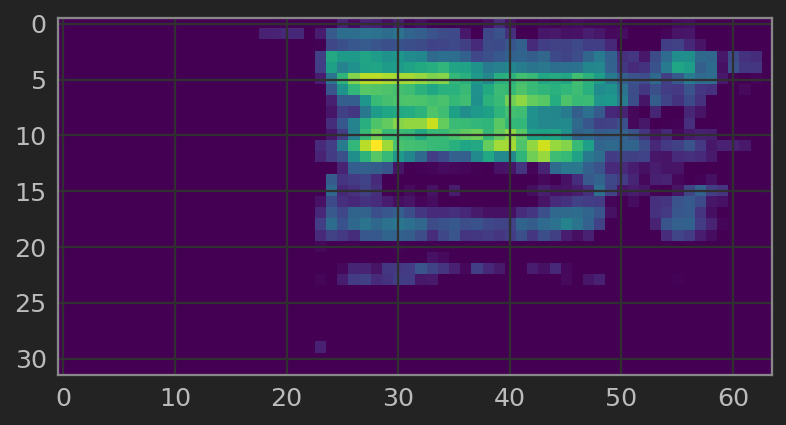

In [394]:
if __name__ == '__main__':
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    from jupyterthemes import jtplot
    jtplot.style()
    
    import IPython.display as ipd
    
    f = '/d2/caches/tf-speech/train/audio/dog/00b01445_nohash_0.wav'
    dg = DataGenerator('/d2/caches/tf-speech/train/audio')
    dg.n_mels = 32
    dg.msg_w = 64
    b = wavfile.read(f)[1]
    m = dg.msg(b)
    plt.imshow(m)

In [395]:
c = librosa.effects.pitch_shift(b.astype(np.float32), 16000, 10)
ipd.Audio(c, rate=16000)

In [396]:
a = dg.generate_silence_audio()
ipd.Audio(a, rate=dg.sample_rate)

volume 0.5970122561379819
volume 0.9122698375562508
volume 0.09616690022193095
volume 0.6471719584161021
volume 0.5451843779625656
pitch 7.483037097738329


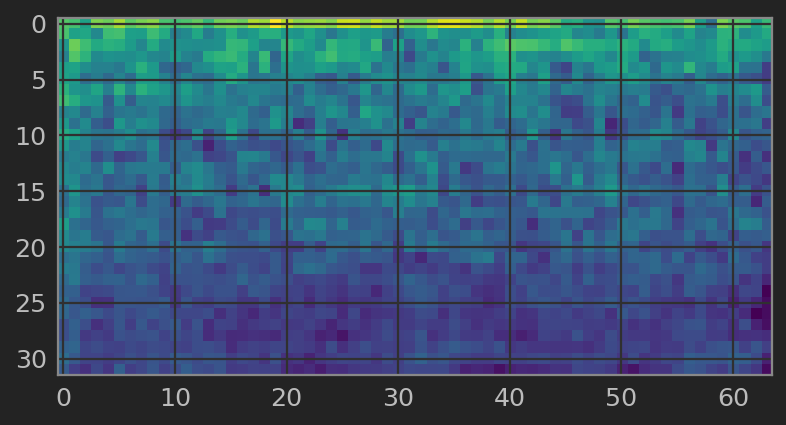

In [397]:
plt.imshow(dg.msg(a))

In [302]:
for i, v in dg.mix_with.items():
    print(i, v)

/d2/caches/tf-speech/train/audio/_background_noise_/white_noise.wav {'probability': 0.1, 'volume': [0.05, 0.3]}
/d2/caches/tf-speech/train/audio/_background_noise_/pink_noise.wav {'probability': 0.1, 'volume': [0.05, 0.3]}
/d2/caches/tf-speech/train/audio/_background_noise_/doing_the_dishes.wav {'probability': 0.1, 'volume': [0.25, 1.0]}
/d2/caches/tf-speech/train/audio/_background_noise_/exercise_bike.wav {'probability': 0.1, 'volume': [0.25, 1.0]}
/d2/caches/tf-speech/train/audio/_background_noise_/dude_miaowing.wav {'probability': 0.1, 'volume': [0.25, 1.0]}
/d2/caches/tf-speech/train/audio/_background_noise_/running_tap.wav {'probability': 0.1, 'volume': [0.25, 1.0]}
